In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob

In [4]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
from newlanespipeline import computational_graph as cg
from newlanespipeline import parameters as cg_params

## Initialization

In [6]:
cm = np.load('serialize/camera_matrix.npy')
dc = np.load('serialize/dist_coefs.npy')

In [7]:
CANVAS_SZ = (500, 1500)
OFFSET_X = 100
OFFSET_Y = 0

straight_images_files = ('test_images/straight_lines1.jpg', 'test_images/straight_lines2.jpg')
straight_images = [lanelines.open_image(f) for f in straight_images_files]
straight_images_undist = [cv2.undistort(im, cm, dc) for im in straight_images]

warp_src = roadplane.define_flat_plane_on_road(straight_images_undist, x_offset=0)
warp_src[1, 0] += 8 # <- a hack
warp_dst = lanelines.get_rectangle_corners_in_image(CANVAS_SZ, offset_x=OFFSET_X, offset_y=OFFSET_Y)

M = cv2.getPerspectiveTransform(warp_src, warp_dst)
Minv = cv2.getPerspectiveTransform(warp_dst, warp_src)

In [8]:
test_images = [lanelines.open_image(f) for f in glob('test_images/*.jpg')]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

In [9]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images_undist]

## Pipeline

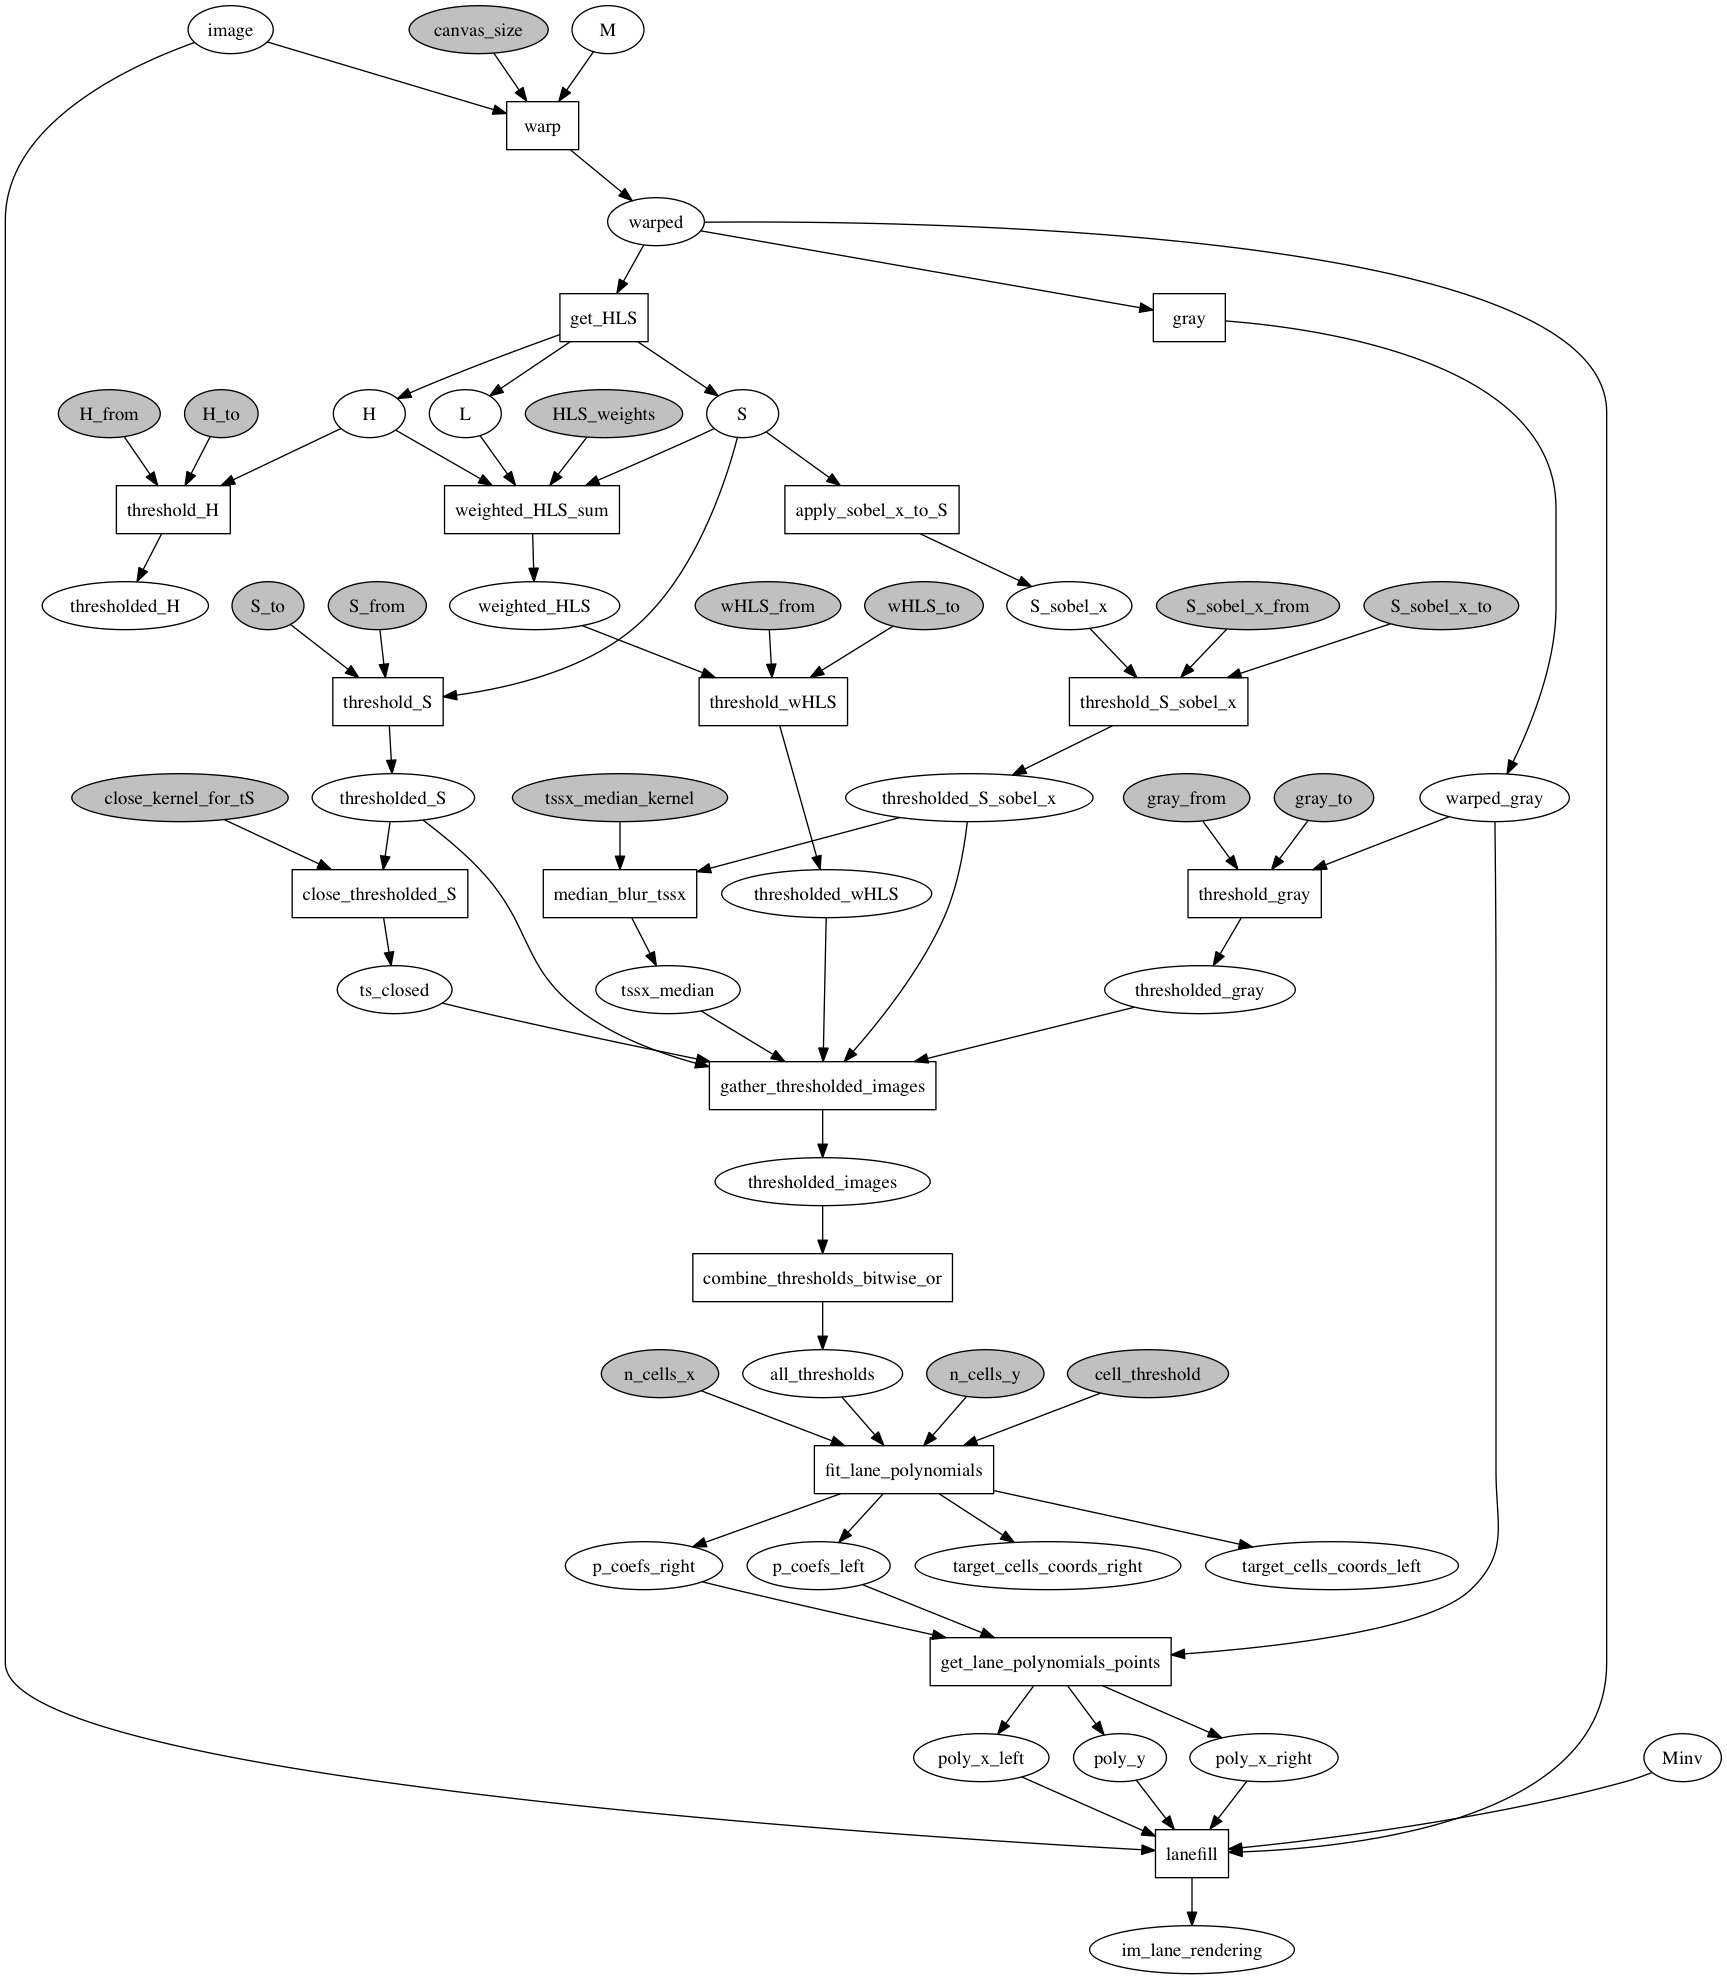

In [10]:
runner = CompGraphRunner(cg, frozen_tokens=cg_params)
runner.run(image=test_images_undist[1], M=M, Minv=Minv)

nxpd.draw(runner.token_manager.to_networkx())

## Experiments

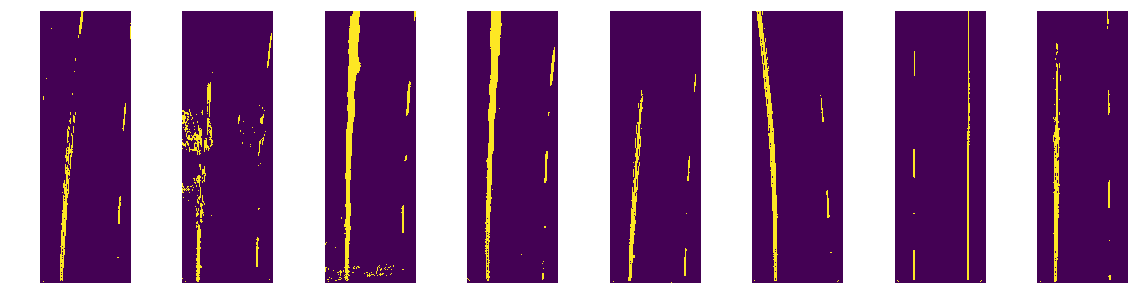

In [11]:
plt.figure(figsize=(20, 5))

for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M, Minv=Minv)
    
    plt.subplot(1, 8, i+1)
    plt.imshow( runner['all_thresholds'])
    _ = plt.axis('off')

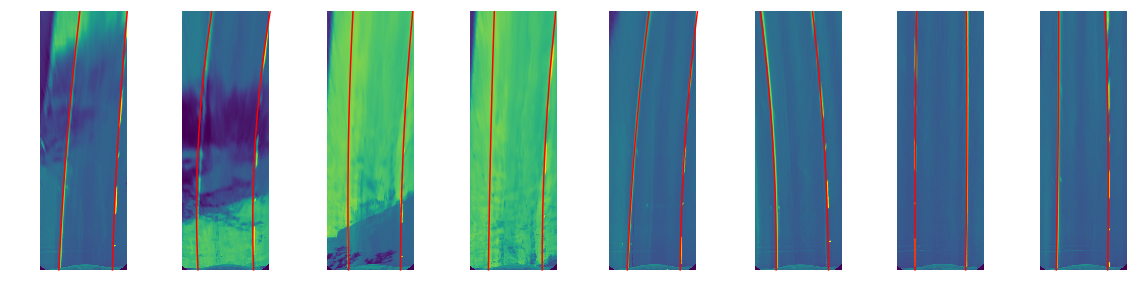

In [12]:
plt.figure(figsize=(20, 5))

for i, im in enumerate(test_images_undist):
    plt.subplot(1, 8, i+1)
    _ = plt.axis('off')
    
    runner.run(image=im, M=M, Minv=Minv)
    
    plt.imshow(runner['warped_gray'])
    
    plt.plot(runner['poly_x_left'], runner['poly_y'], color='r')
    plt.plot(runner['poly_x_right'], runner['poly_y'], color='r')

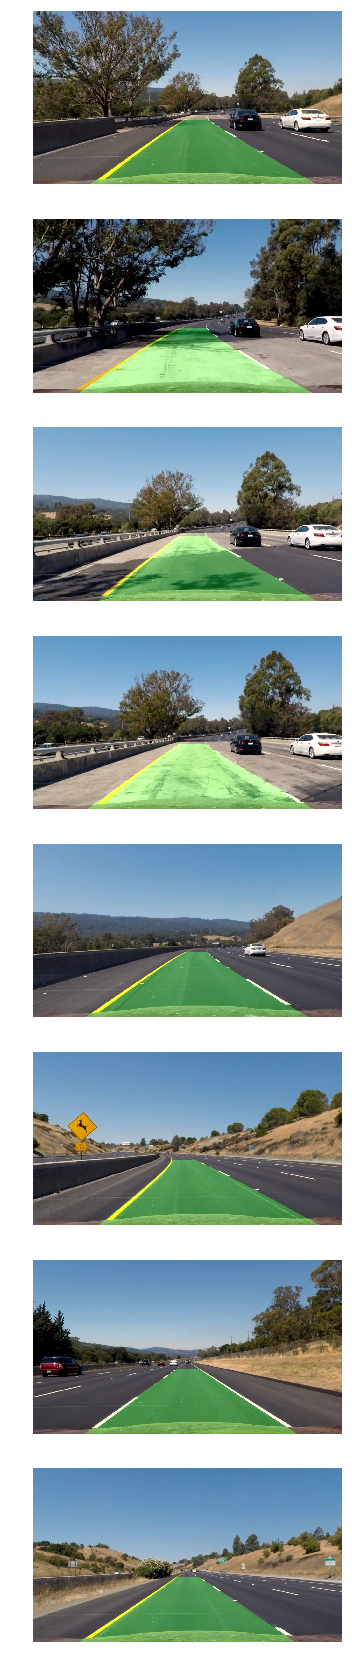

In [13]:
plt.figure(figsize=(8, 30))

for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M, Minv=Minv)
    
    plt.subplot(8, 1, i+1)
    plt.imshow( cv2.cvtColor( runner['im_lane_rendering'], cv2.COLOR_BGR2RGB ) )
    _ = plt.axis('off')